<h1> Scrape Data -> preprocess/clean -> scale -> regression </h1>
<h3>by Angelo Cortez (UC Irvine)  Lee Sangbec (UC Berkeley) </h3>

In [1]:
# Import our needed modules
# numpy and pandas to manipulate the csv's dataframe components
import numpy as np
import pandas as pd

In [2]:
tyo=pd.read_csv('listings.csv')

In [3]:
tyo.dropna(axis=0, how='all', inplace=True)

In [4]:
# Then we import our listings file. We do not want to see blank rows, so we shall delete them with the .dropna method

# We want to look if there are any duplicates in the dataframe. We can achieve this by comparing listing ID's.
# The url can be parsed through with the split method. 
tyo.url = tyo.url.apply(lambda x:str(x).split('?')[0])
tyo = tyo.drop_duplicates(subset=['url'])

In [5]:
# We want to reconstruct the Entire_home/apt feature with dummy variables. 
# This is achievable by using the .map function.

tyo['Entire_home/apt'] = tyo.room_type.map({'Entire home/apt':1, 'Private room': 0, 'Shared room': 0})


tyo['book_instantly'] = tyo.instant_book.map({True:1, False: 0 })
tyo.drop('instant_book', axis=1, inplace = True)

# We don't need the url feature. 
tyo.drop('url', axis=1, inplace=True)

In [6]:
# we take care of dummy variables using this function, or we can use the .fillna further down below

booleans=[]
for i in tyo.bed_type:
    if i == 'Real Bed':
        booleans.append(1)
    else:
        booleans.append(0)
tyo['bed_type'] = booleans


In [7]:
# Dropping the cancel policy since it is uninteresting. 
tyo.drop('cancel_policy',axis=1, inplace=True)   

In [8]:
tyo.drop(0, axis=0, inplace=True)

# Set X and Y variables here. 

X = tyo.drop(['price','amenities','response_time'], axis=1)
y = tyo.price


In [9]:
# Imputer - replaces the null values using a strategy and axis. 
# second way to fill nullv values


from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy = 'median', axis=0)
imp.fit(X)
X = pd.DataFrame(data=imp.transform(X), columns=X.columns)

# We can see that there are no missing values in each column. 
X.isnull().sum().sort_values(ascending=False).head() 

book_instantly        0
Entire_home/apt       0
satisfaction_guest    0
rev_count             0
response_rate         0
dtype: int64

In [10]:
# We will use this to compare our three hypotheses 
def print_best(gridsearch):
    '''Print the best estimator, best parameters, and best score given a gridsearch method.'''
    print('Best estimator: {} \n Hyperparameters: {} \n Best score: {}'.format(gridsearch.best_estimator_,
                                                                           gridsearch.best_params_, 
                                                                           abs(gridsearch.best_score_)))

<h1>Hypothesis 1: </h1>
First, we want to check the error while using the MinMaxScaler(), then we shall use the StandardScaler() to see which provides the more accurate median absolute error. 

[ 21.77544359  20.92288508  20.75108711  28.3764615   21.23460242
  23.44951189]
Processing GSCV ... 
GSCV finished ...


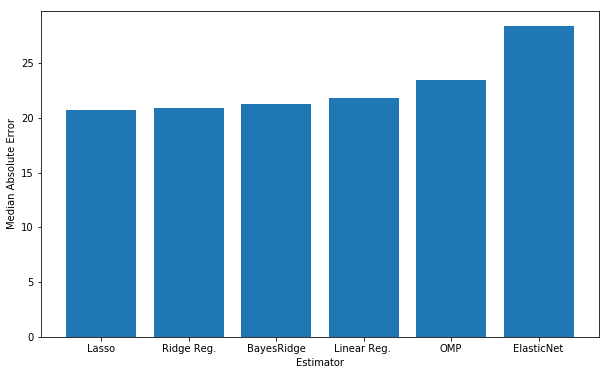

In [19]:
# get median error values using sklearn. 
# use matplotlib to graph the calculations


from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline

rs = 1

ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear Reg. ', 'Ridge Reg.', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=20)


scaler = MinMaxScaler()
X_train_MMS = scaler.fit_transform(X_train)
X_test_MMS = scaler.transform(X_test)

for e in ests:
    e.fit(X_train_MMS, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test_MMS))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(10,6))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')
print(errvals)

# calculate median error using gradient boosting regression
print('Processing GSCV ... ')
n_est = 200
tuned_parameters = {
    "n_estimators":      [ 100, 200,300, 400],
    "max_depth" :        [ 3   , 4    , 5  , 6],
    "learning_rate":     [ 0.01, 0.005, 0.1],
    "min_samples_split" :[ 4,    6    , 8],
    "loss" :             [ 'ls', 'lad'                  ],
    'max_features':      [ 1.0, 0.8,  0.5, 0.3   , 0.1    ]}


gbr = ensemble.GradientBoostingRegressor()
clf1 = GridSearchCV(gbr, cv=4, param_grid=tuned_parameters, scoring='neg_median_absolute_error')
preds1 = clf1.fit(X_train_MMS, y_train)
print('GSCV finished ...')

In [20]:
print_best(clf1)

Best estimator: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=0.1,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=4, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False) 
 Hyperparameters: {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 3, 'max_features': 0.1, 'min_samples_split': 4, 'n_estimators': 300} 
 Best score: 16.71754672236019


<h1>Hypothesis 2: </h1>
Consequently, we want to check if we can achieve a lower error rate while keeping the hyperparameters constant, but by using a StandardScaler() instead of MinMaxScaler(). 

[ 21.77544359  21.70765704  21.05106617  20.88240077  22.09435131
  23.44951189]
Processing GSCV ... 
GSCV finished ...


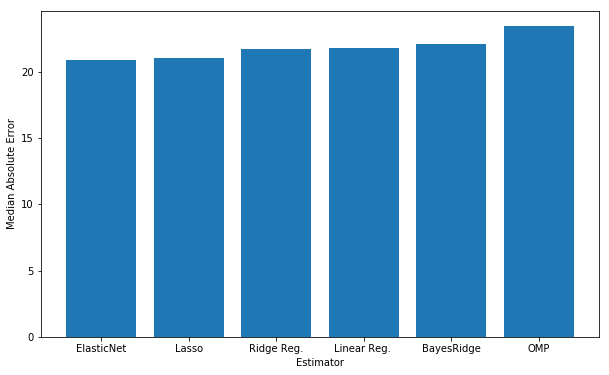

In [21]:
# get median error values using sklearn. 
# use matplotlib to graph the calculations

%matplotlib inline

rs = 1

ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear Reg. ', 'Ridge Reg.', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=20)


scaler = StandardScaler()
X_train_SS = scaler.fit_transform(X_train)
X_test_SS = scaler.transform(X_test)
    


for e in ests:
    e.fit(X_train_SS, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test_SS))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(10,6))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')
print(errvals)

# calculate median error using gradient boosting regression
print('Processing GSCV ... ')
n_est = 200
tuned_parameters = {
    "n_estimators":      [ 100, 200, 300, 400],
    "max_depth" :        [ 3   , 4    , 5  , 6],
    "learning_rate":     [ 0.01, 0.005, 0.1],
    "min_samples_split" :[ 4,    6    , 8],
    "loss" :             [ 'ls', 'lad'                  ],
    'max_features':      [ 1.0, 0.8,  0.5, 0.3   , 0.1    ]}


gbr = ensemble.GradientBoostingRegressor()
clf2 = GridSearchCV(gbr, cv=4, param_grid=tuned_parameters, scoring='neg_median_absolute_error')
preds = clf2.fit(X_train_SS, y_train)
print('GSCV finished ...')

In [22]:
print_best(clf2)

Best estimator: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=4, max_features=0.3,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=8, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False) 
 Hyperparameters: {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 4, 'max_features': 0.3, 'min_samples_split': 8, 'n_estimators': 200} 
 Best score: 16.604628005271273


<h1>Hypothesis 3: </h1>
We want to see how the model performs without scaling. 

[ 21.77544359  21.88929822  21.65272339  23.17302765  22.72625336
  23.44951189]
Processing GSCV ... 
GSCV finished ...


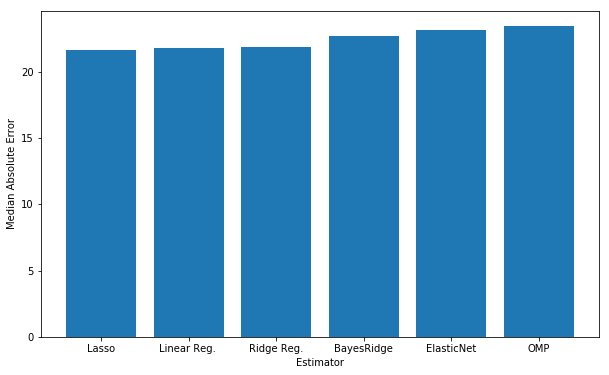

In [24]:
# get median error values using sklearn. 
# use matplotlib to graph the calculations

%matplotlib inline

rs = 1

ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear Reg. ', 'Ridge Reg.', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(10,6))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')
print(errvals)

# calculate median error using gradient boosting regression
print('Processing GSCV ... ')

tuned_parameters = {
    "n_estimators":      [ 100, 200,300,400],
    "max_depth" :        [ 3   , 4    , 5  , 6],
    "learning_rate":     [ 0.01, 0.005, 0.1],
    "min_samples_split" :[ 4,    6    , 8],
    "loss" :             [ 'ls', 'lad'                  ],
    'max_features':      [ 1.0, 0.8,  0.5, 0.3   , 0.1    ]}


gbr = ensemble.GradientBoostingRegressor()
clf3 = GridSearchCV(gbr, cv=4, param_grid=tuned_parameters, scoring='neg_median_absolute_error')
preds = clf3.fit(X_train, y_train)
print('GSCV finished ...')

In [15]:
print_best(clf3)

Best estimator: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='lad', max_depth=3, max_features=1.0,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=4, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False) 
 Hyperparameters: {'learning_rate': 0.01, 'loss': 'lad', 'max_depth': 3, 'max_features': 1.0, 'min_samples_split': 4, 'n_estimators': 200} 
 Best score: 15.965436260789664


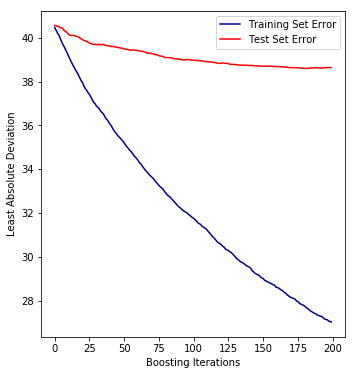

In [36]:
# plot error for each round of boosting
test_score = np.zeros(n_est, dtype=np.float64)
best = bestparams
train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

In [37]:

feature_importance = clf.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

#As expected, person capacity was the most important variable when predicting price

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5]), <a list of 11 Text xticklabel objects>)

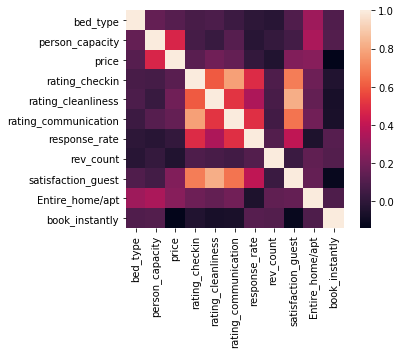

In [17]:
# Below we can see the Pearson's r correlation of the listings data. 
# Pearson's r measures the strength of the linear relationship between two variables. 
# We can see that the most correlated to price is the person capacity of a listing. 

pears= X = tyo.drop(['amenities','response_time'], axis=1)
import seaborn as sns
%matplotlib inline
corr_matrix = pears.corr()
sns.heatmap(corr_matrix, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

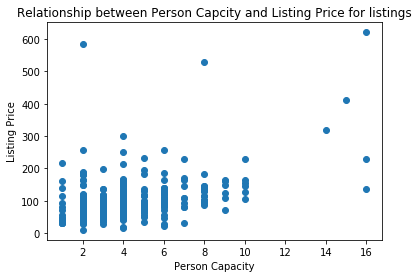

In [18]:
plt.scatter(tyo.person_capacity,tyo.price)
plt.xlabel("Person Capacity")
plt.ylabel("Listing Price")
plt.title("Relationship between Person Capacity and Listing Price for listings")
plt.show()

<h2> General conclusion: Scaling was not necessary to perform on the dataset since we achieved lower median absolute error when scaling was not implemented.  </h2>